### Brats

In [5]:
import torch
import numpy as np
import h5py
from load_brats_all_modalities import load_data
import matplotlib.pyplot as plt

In [6]:
##### val data dir : /srv/Data/playground_data/brats/brats_validation_data/MICCAI_BraTS2020_ValidationData
#### train data : /srv/Data/playground_data/brats/brats_training_data/data_raw

data_dir = '/srv/Data/playground_data/brats/brats_validation_data/MICCAI_BraTS2020_ValidationData'
h5_path = '/srv/Data/playground_data/brats/h5_test_all_modalities'
# class_cond = False

In [7]:
dataset = load_data(brats_path=data_dir,h5_path=h5_path)
loader = torch.utils.data.DataLoader(dataset,batch_size = 1,shuffle = False ,num_workers= 1)

In [8]:
# with h5py.File(h5_path, 'r') as data:
#     t1 = image['t1'].squeeze()
#     t2 = image['t2'].squeeze()
#     t1ce= image['t1ce'].squeeze()
#     flair = image['flair'].squeeze()
#     seg = image['seg'].squeeze()
#     x = np.concatenate((t1,t2,t1ce,flair,seg),axis=1)
#     plt.imshow(x,cmap='gray')
    
for idx,image in enumerate(loader):
    inp1= image[0][0,0,:,:].numpy()
    inp2 = image[0][0,1,:,:].numpy()
    inp3 = image[0][0,2,:,:].numpy()
    inp4 = image[0][0,3,:,:].numpy()
#     break
    

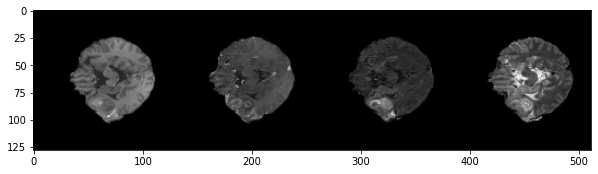

In [5]:
x  = np.concatenate((inp1,inp2,inp3,inp4),axis=1)
plt.figure(figsize=(10,10))
plt.imshow(x,cmap='gray')

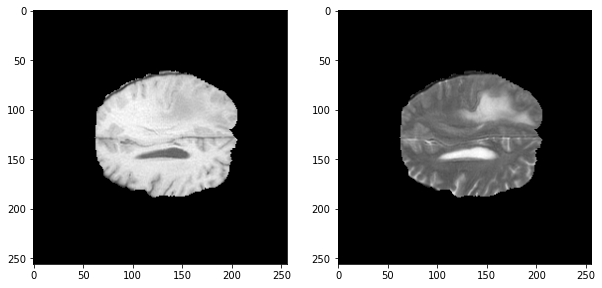

In [4]:
for idx,image in enumerate(loader):
    t1 = image['image_t1']
    t2 = image['image_t2']
    fig = plt.figure(figsize=(10,10))
    fig.add_subplot(1,2,1)
    plt.imshow(t1.squeeze(),cmap = 'gray')
    fig.add_subplot(1,2,2)
    plt.imshow(t2.squeeze(),cmap = 'gray')
    break

### IXI Loader

In [22]:
import torch
import matplotlib.pyplot as plt
import glob
# from load_ixi import load_data

In [23]:
data_path = '/srv/Data/playground_data/ixi_data/ixi'
h5_path = '/srv/Data/playground_data/ixi_data/h5_ixi'

In [24]:
# # dataset = load_data(data_path,h5_path)
# data_path = data_path + '/**_Guys/T2/NIfTI/**'
# # for x in glob.glob(data_path):
# #     print(x)
    


In [35]:
import nibabel as nib

pa = '/srv/Data/playground_data/ixi_data/ixi/422_Guys/T2/NIfTI/IXI422-Guys-1071-T2.nii.gz'
img = nib.load(pa).get_fdata()
transforms_1 = Compose(
    [
     AddChanneld(('image')),
     Orientationd(('image'),'RAS'),
     ScaleIntensityD(('image',)),
     ToTensord(('image')),
#      Rotate90(k=2,spatial_axes=(0,1)),
    ])
data = {'image':img}
img1 = transforms_1(data)

t = Rotate90(k=2,spatial_axes=(0,1))
new_img=t(img1['image'][0,:,:,:])
new_img.shape
new_img = torch.rot90(img1['image'][0,:,:,:],1)
img1['image'][0,:,:,:].shape, new_img.shape

((256, 256, 130), (256, 256, 130))

In [37]:
# slice = 60
# fig,ax = plt.figure()
# ax = plt.subplot(1,2,1)
# plt.imshow(img[:,:,slice],cmap = "gray")
# # plt.imshow(img1['image'][0,:,:,slice],cmap='gray')
# plt.subplot(1,2,2)
# plt.imshow(new_img[:,:,slice],cmap = "gray")
# # plt.imshow(img[:,:,slice],cmap = "gray")

TypeError: cannot unpack non-iterable Figure object

<Figure size 432x288 with 0 Axes>

In [6]:
img.shape

(256, 256, 130)

In [5]:
import os
import glob
import numpy as np
import torch
from tqdm.notebook import tqdm
from monai.data import ITKReader,NibabelReader
from monai.transforms import LoadImage, LoadImaged
from monai.transforms import (
    Orientationd, AddChanneld, Compose, ToTensord, Spacingd,Resized,ScaleIntensityD,ResizeWithPadOrCropd,Rotate90
    # ScaleIntensityD, ScaleIntensityRangeD, AdjustContrastD, RandAffined, ToNumpyd,RepeatChannelD
)
from monai.data import Dataset
import h5py
import threading

# modality_list = ['t1', 't2']
# def comb_path(path):
#     dict_ = {}
#     for itr_ in modality_list:
#         uniq_ = path.split('/')[-1].split('_')
#         basepath = "/".join(path.split('/')[0:-1])
#         b = '_'.join(uniq_[0:-1])
#         c = '/'.join([basepath,b])
#         itr__ = itr_+'.nii'
#         d ='_'.join([c,itr__])
#         dict_.update({itr_:d})
        
#     return dict_

def load_data(ixi_path,h5_path):
    ixi_path = ixi_path + '/**_Guys/T2/NIfTI/**'
    transforms_1 = Compose(
    [
     AddChanneld(('image')),
     Orientationd(('image'),'RAS'),
     ScaleIntensityD(('image',)),
     ToTensord(('image')),
    ])
    
    dataset = H5CachedDataset(ixi_path,transforms_1,h5cachedir=h5_path)
    
    #### preparing dataloader#####
    
#     brats_loader = torch.utils.data.DataLoader(dataset,batch_size = batch_size ,\
#                                                shuffle = True ,num_workers= 1)
    
    return dataset

class H5CachedDataset(Dataset):
    def __init__(self, datapath,
                 transforms_1, 
                 nslices_per_image = 130 ,
                 start_slice = 10,
                 end_slice = 30,
                 h5cachedir=None):
       #         self.lock = threading.Lock()
        if h5cachedir is not None:
            if not os.path.exists(h5cachedir):
                os.mkdir(h5cachedir)
            self.cachedir = h5cachedir
        niilist=[]
        for x in glob.glob(datapath):
#             print(x)
#             t1,t2 = comb_path(x)['t1'] ,comb_path(x)['t2']
            niilist.append(x)
#             niilist.append(t2)

        self.datalist = niilist
#         print(self.datalist)
        self.xfms = transforms_1
                    
        #### 3d image loader from monai
        
        self.loader = LoadImage()
        self.loader.register(NibabelReader())
        
        #### start_slice & end_slice---> slices to be truncated in each volume vol[:,:,start_slice:-end_slice]
        
        self.start_slice = start_slice
        self.end_slice = end_slice
        
        self.nslices = nslices_per_image - self.end_slice

        
    def __len__(self):
        #### total number of slices in all the volumes
        return len(self.datalist)*(self.nslices - self.start_slice)
    
    def clear_cache(self):
        #### function to clear the directory storing h5 files (used for caching the h5 files)
        for fn in os.listdir(self.cachedir):
            os.remove(self.cachedir+'/'+fn)
            
    def __getitem__(self,index):
        #### ditionary to store data slicewise
        data = {}
        label ={}
#      
#        
        filenum = index // (self.nslices - self.start_slice)


        slicenum = index % (self.nslices - self.start_slice)

        slicenum += self.start_slice
        
        #### Extract the datafile location & mask file location based on filenum
#         print(f"filenum {filenum} and length {len(self.datalist)}")
        datalist_filenum = self.datalist[filenum]

        loc_data = datalist_filenum

#         l = loc_data.split('/')[-1].split('_')[-1]
#         if( l == 't1.nii'):
#             label["y"] = np.array((0))
#         if( l == 't2.nii'):
#             label["y"] = np.array((1))
            
        ##### if h5 exists for the current volume fill data dictionary with current slice number
        if self.cachedir is not None:
            h5name = self.cachedir+'/%d.h5' % filenum

            ptname = self.cachedir+'/%d.pt' % filenum

            if os.path.exists(h5name):
                
                with h5py.File(h5name,'r',libver='latest', swmr=True) as itm:
                    for key in itm.keys():                       
                        data[key]=torch.from_numpy(itm[key][:,:,:,slicenum])
#                 data['image_meta_dict']={'affine':np.eye(3)} # FIXME: loses spacing info - can read from pt file


        ##### if data dictionary is empty
        if len(data)==0:
            
            imgdata, meta = self.loader(loc_data)
#             imgdata_padded = torch.zeros((256,256,155))
#             imgdata_padded[8:-8,8:-8,:] = imgdata

            
            #### store volume wise image & mask data,metadata in a dictionary 
            data_i = {'image':imgdata}

            #### transform the data dictionary
            data3d = self.xfms(data_i)

            if self.cachedir is not None:
                other = {}

                with h5py.File(h5name,'w',libver='latest') as itm:
                    itm.swmr_mode = True
                    for key in data3d:
                        if key in ['image']:                             
                            img_npy = data3d[key].numpy()

                            shp = img_npy.shape
                            
                            chunk_size = list(shp[:-1])+[1]
#                             print(chunk_size)
                            ds = itm.create_dataset(key,shp,chunks=tuple(chunk_size),dtype=img_npy.dtype)
                            ds[:]=img_npy[:]
#                             print('ds shape',ds.shape)
                            ds.flush()
                    else:
                        other[key]=data3d[key]
                torch.save(other,ptname)
                
            data = {'image':data3d['image'][:,:,:,slicenum]}

            
        if len(data)>0:
#             print("**",data.keys())
#             res = self.xfms2(data)
            res = data
#             print(res.keys())
#             res['image'] = res['image'].float()
            res['filenum'] = filenum
            res['slicenum'] = slicenum
            res['idx'] = index
            return res['image'] , {"y":np.array((1))}

        else:
            # replace with random
            return self.__getitem__(np.random.randint(len(self.datalist)))


In [6]:
cls = load_data(data_path,h5_path)

In [7]:
x = cls.__getitem__(100)

### Brats Loader

In [2]:
import torch
from load_brats_sampler import load_data
import matplotlib.pyplot as plt
import sys
import argparse
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
brats_path = '/srv/Data/playground_data/brats/brats_training_data/data_raw'
h5_path = '/srv/Data/playground_data/brats/h5_t1_t2'
class_cond=True

dataset = load_data(brats_path,h5_path)


In [5]:
x = dataset.__getitem__(5)


key is image
itm is <HDF5 file "0.h5" (mode r)>
**


In [20]:
loader = torch.utils.data.DataLoader(dataset,batch_size = 1,\
                                              shuffle = True ,num_workers= 1)

In [21]:
brats_loader = iter(loader)
image= next(brats_loader) 
# print(f"label {label['y']}")

In [22]:
t1 = image['image_t1']
t2 = image['image_t2']
t1.shape

torch.Size([1, 1, 256, 256])

In [26]:
x = t1.detach().cpu().squeeze().numpy()

x = x[:,:,np.newaxis]
print(x.shape)
import numpy as np
y =np.transpose(x,(1,2,0))
y.shape

(256, 256, 1)


(256, 1, 256)

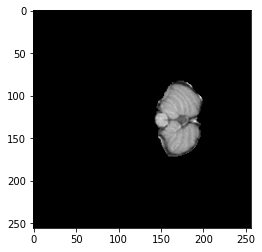

In [6]:
import matplotlib.pyplot as plt
plt.imshow(t1.squeeze(),cmap ="gray")

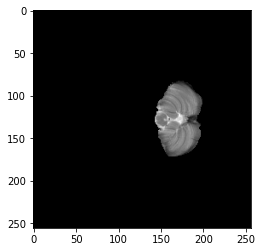

In [7]:
plt.imshow(t2.squeeze(),cmap ="gray")

In [ ]:
image.shape

In [ ]:
timesteps= torch.tensor([5] * 1)

In [ ]:
attention_resolutions = "16,8"

In [ ]:
attention_ds = []
for res in attention_resolutions.split(","):
    attention_ds.append(256 // int(res))

In [ ]:
from unet_dummy import UNetModel
learn_sigma = True
model = UNetModel(
        image_size=256,
        in_channels=1,
        model_channels=128,
        out_channels=(1 if not learn_sigma else 2),
        num_res_blocks=3,
        attention_resolutions=tuple(attention_ds),
        dropout=0.1,
        channel_mult=(1, 1, 2, 2, 4, 4),
        num_classes=2,
        use_checkpoint=False,
        use_fp16=False,
        num_heads=4,
        num_head_channels=-1,
        num_heads_upsample=-1,
        use_scale_shift_norm=True,
        resblock_updown=True,
        use_new_attention_order=False)

In [ ]:
out = model(image,timesteps,y)

In [12]:
from script_util_dummy import (
    NUM_CLASSES,
    model_and_diffusion_defaults,
    classifier_defaults,
    create_model_and_diffusion,
    create_classifier,
    add_dict_to_argparser,
    args_to_dict,
)

In [ ]:
label ### 0-->T1, 1-->T2, shape = (N,1,256,256)

In [ ]:
input_image = image
input_image.shape

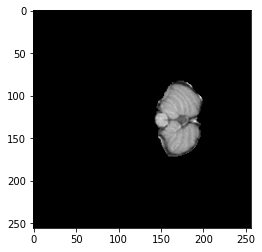

In [10]:
plt.imshow(t1.squeeze()[:,:],cmap = "gray")

In [11]:
classifier_model_path = '/srv/Data/playground_data/checkpoint_folder/T1T2_classifier_checkpoint/Brats-2023-01-16/model020000.pt'

In [15]:
classifier = create_classifier(256,False,128,2,'8',True,True,'attention')

In [19]:
timesteps= torch.tensor([0] * 1)
label = {"y":torch.Tensor((0))}

In [20]:
model = classifier.load_state_dict(torch.load(classifier_model_path))
# print(classifier.keys())

In [21]:
# model = model.load_state_dict(classifier)

In [25]:
out= classifier(t1,timesteps)
out

tensor([[ 3.4066, -2.2654]], grad_fn=<SelectBackward>)

In [26]:
# loss = F.cross_entropy(out, label['y'], reduction="none")

In [ ]:
loss

In [ ]:
import sys
import glob
# import torch
from monai.transforms import (
    Orientationd, AddChanneld, Compose, ToTensord, Spacingd,Resized,ScaleIntensityD,ResizeWithPadOrCropd
    # ScaleIntensityD, ScaleIntensityRangeD, AdjustContrastD, RandAffined, ToNumpyd,RepeatChannelD
)
# import slice_data_h5 as sdl_h5
transforms_1 = Compose(
    [
     AddChanneld(('image')),
     Orientationd(('image'),'RAS'),
#      Spacingd(('image','label'),(1,1,1)),        
#      Resized(keys = ('image_t1','image_t2'),spatial_size = (128, 128,-1),mode = 'trilinear' ,align_corners = True),
#      Resized(keys = ('label'),spatial_size = (128, 128,-1),mode = 'nearest' ),
     ScaleIntensityD(('image',)),
     ToTensord(('image')),
    ]
)

In [ ]:
brats_path = '/srv/Data/playground_data/brats/brats_training_data/data_raw/**/**_t1.nii'
h5_path = '/srv/Data/playground_data/brats/h5_brats'

In [ ]:
data = H5CachedDataset(brats_path,transforms_1,h5cachedir=h5_path)

In [ ]:
d= data.__getitem__(7)

In [ ]:
import numpy
a = numpy.array(0)

In [ ]:
a

In [ ]:
plt.imshow(d['image_t1'].squeeze(),cmap='gray')

In [ ]:
brats_loader = torch.utils.data.DataLoader(data,batch_size = 5 ,\
                                           shuffle = True ,num_workers= 1)

In [ ]:
def func(brats_loader):
    while True:
        yield from brats_loader

In [ ]:
x_= func(brats_loader)
img,labe = next(x_)

In [ ]:
img_=img.squeeze()
plt.imshow(img_[2,:,:])

In [ ]:
obj = iter(brats_loader)
img,label = next(obj)

In [ ]:
plt.imshow(img.squeeze()[2,:,:])

In [ ]:
for idx, data in enumerate(brats_loader):
    img = data[0]
    label = data [1]
    print(img['image'].shape)

In [ ]:
data[0]['image'].shape

### Classifier

sorted_classes names {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}  
out_dict = {'y': array(8)}

In [ ]:
modality_list = ['t1', 't2']
def comb_path(path):
    dict_ = {}
    for itr_ in mod_list:
        uniq_ = path.split('/')[-1].split('_')
        
        basepath= "/".join(path.split('/')[0:-1])
        
        b = '_'.join(uniq_[0:-1])
        
        c = '/'.join([basepath,b])
#         print(f'c : {c} \n a : {basepath}')
        itr__ = itr_+'.nii'
        d ='_'.join([c,itr__])
        
        dict_.update({itr_:d})
        
    return dict_

### loader for diffusion model

In [ ]:
import os
import glob
import numpy as np
import torch
import nibabel
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from monai.data import ITKReader,NibabelReader
from monai.transforms import LoadImage, LoadImaged
from monai.transforms import (
    Orientationd, AddChanneld, Compose, ToTensord, Spacingd,Resized,ScaleIntensityD,ResizeWithPadOrCropd
    # ScaleIntensityD, ScaleIntensityRangeD, AdjustContrastD, RandAffined, ToNumpyd,RepeatChannelD
)
from monai.data import Dataset
import h5py
import threading

def load_data(brats_path,h5_path):
    brats_path = brats_path + '/**/**_t1.nii'
    transforms_1 = Compose(
    [
     AddChanneld(('image_t1','image_t2')),
     Orientationd(('image_t1','image_t2'),'RAS'),
     ScaleIntensityD(('image_t1','image_t2',)),
     ToTensord(('image_t1','image_t2')),
    ]
)
    
    dataset = H5CachedDataset(brats_path,transforms_1,h5cachedir=h5_path)
    
    return dataset 

mod_list = ['t1', 't2']
def comb_path(path):
    dict_ = {}
    for itr_ in mod_list:
        uniq_ = path.split('/')[-1].split('_')
        a= "/".join(path.split('/')[0:-1])
        b = '_'.join(uniq_[0:-1])
        c = '/'.join([a,b])
        itr__ = itr_+'.nii'
        d ='_'.join([c,itr__])
        dict_.update({itr_:d})
        
    return dict_

class H5CachedDataset(Dataset):
    def __init__(self, datapath,
                 transforms_1, 
                 nslices_per_image = 155 ,
                 start_slice = 10,
                 end_slice = 10,
                 h5cachedir=None):
       #         self.lock = threading.Lock()
        if h5cachedir is not None:
            if not os.path.exists(h5cachedir):
                os.mkdir(h5cachedir)
            self.cachedir = h5cachedir
        niilist=[]
        for x in glob.glob(datapath):
            niilist.append(comb_path(x))

        self.datalist = niilist

        self.xfms = transforms_1

        #### 3d image loader from monai
        
        self.loader = LoadImage()
        self.loader.register(NibabelReader())  
        #### start_slice & end_slice---> slices to be truncated in each volume vol[:,:,start_slice:-end_slice]
        
        self.start_slice = start_slice
        self.end_slice = end_slice
        
        self.nslices = nslices_per_image - self.end_slice
#         print(self.nslices)
        
    def __len__(self):
        #### total number of slices in all the volumes
        return len(self.datalist)*(self.nslices - self.start_slice)
    
    def clear_cache(self):
        #### function to clear the directory storing h5 files (used for caching the h5 files)
        for fn in os.listdir(self.cachedir):
            os.remove(self.cachedir+'/'+fn)
            
    def __getitem__(self,index):
        #### ditionary to store data slicewise
        data = {}
        label = {}
        
        filenum = index // (self.nslices - self.start_slice)


        slicenum = index % (self.nslices - self.start_slice)

        slicenum += self.start_slice
        
        #### Extract the datafile location & mask file location based on filenum
        datalist_filenum = self.datalist[filenum]

        loc_data_t1 = datalist_filenum['t1']
        loc_data_t2 = datalist_filenum['t2']
#         print(loc_data_t2)

        label = {"y":[np.array((0))]}
        label["y"].append(np.array((1)))
        
        ##### if h5 exists for the current volume fill data dictionary with current slice number
        if self.cachedir is not None:
            h5name = self.cachedir+'/%d.h5' % filenum

            ptname = self.cachedir+'/%d.pt' % filenum

            if os.path.exists(h5name):
                
                with h5py.File(h5name,'r',libver='latest', swmr=True) as itm:
                    for key in itm.keys():                       
                        data[key]=torch.from_numpy(itm[key][:,:,:,slicenum])
#                 data['image_meta_dict']={'affine':np.eye(3)} # FIXME: loses spacing info - can read from pt file


        ##### if data dictionary is empty
        if len(data)==0:
            imgdata_t1 = nibabel.load(loc_data_t1)
            imgdata_t1 = torch.tensor(imgdata_t1.get_fdata())

#             imgdata_t1, meta_t1 = self.loader(loc_data_t1)
            imgdata_t1_padded = torch.zeros((256,256,155))
            imgdata_t1_padded[8:-8,8:-8,:] = imgdata_t1
#             print("t1 shape",imgdata_t1_padded.shape)
            
            
            imgdata_t2 = nibabel.load(loc_data_t2)
            imgdata_t2 = torch.tensor(imgdata_t2.get_fdata())
            
            imgdata_t2_padded = torch.zeros((256,256,155))
            imgdata_t2_padded[8:-8,8:-8,:] = imgdata_t2

            
            #### store volume wise image & mask data,metadata in a dictionary 
            data_i = {'image_t1':imgdata_t1_padded,\
                      'image_t2':imgdata_t2_padded}
                                           

            #### transform the data dictionary
            data3d = self.xfms(data_i)
#             print(data3d['image'].shape)
            #### Create h5 file for the volume by chunking into the slice shape for data & mask 
            #### Create a .pt file for meta data
            if self.cachedir is not None:
                other = {}

                with h5py.File(h5name,'w',libver='latest') as itm:
                    itm.swmr_mode = True
                    for key in data3d:
                        if key in ['image_t1','image_t2']:                             
                            img_npy = data3d[key].numpy()
#                             if key == 'label':
#                                 img_npy = (img_npy>0).astype('uint8')
                            shp = img_npy.shape
                            
                            chunk_size = list(shp[:-1])+[1]
#                             print(chunk_size)
                            ds = itm.create_dataset(key,shp,chunks=tuple(chunk_size),dtype=img_npy.dtype)
                            ds[:]=img_npy[:]
#                             print('ds shape',ds.shape)
                            ds.flush()
                    else:
                        other[key]=data3d[key]
                torch.save(other,ptname)


            #### fill the data dictionary

            data = {'image_t1':data3d['image_t1'][:,:,:,slicenum],\
                'image_t2':data3d['image_t2'][:,:,:,slicenum]
                
            }
            
#         print(data)
            
        if len(data)>0:
#             print("**",data.keys())
#             res = self.xfms2(data)
            res = data
#             print(res.keys())
            res['image_t1']=res['image_t1'].float()
            res['image_t2']=res['image_t2'].float()
            res['filenum'] = filenum
            res['slicenum'] = slicenum
            res['idx'] = index
            ####### need to convert to torch tensor to remove metadata ##########
            img_t1 = torch.tensor(res['image_t1'])
            img_t2 = torch.tensor(res['image_t2'])
#             print(f'img_t1 shape {img_t1.shape}')
#             print(f'img_t2 shape {img_t2.shape}')
            channel_merged_image = torch.cat((img_t1,img_t2),dim = 0)
            return channel_merged_image,label

        else:
            # replace with random
            return self.__getitem__(np.random.randint(len(self.datalist)))


In [ ]:
brats_path = '/srv/Data/playground_data/brats/brats_training_data/data_raw'
h5_path = '/srv/Data/playground_data/brats/trash'

In [ ]:
h5 = load_data(brats_path,h5_path)

In [ ]:
loader = torch.utils.data.DataLoader(h5,1,shuffle = True, num_workers = 1)

In [ ]:
loader = iter(loader)
data , label = next(loader)

In [ ]:
img = data[0,:,:,:]
img.shape

In [ ]:
out = model(img,timesteps,np.array((0)))

In [ ]:
img = data['image_t1'].squeeze()

In [ ]:
plt.imshow(img[3,:,:],cmap = 'gray')

In [ ]:
a = torch.zeros((5,1,256,256))
b = torch.zeros((5,1,256,256))
x = torch.cat((a,b),dim = 1)
x.shape

In [ ]:
d =comb_path(brats_path+'/**/**_t1.nii')
datapath = d["t1"]
niilist =[]
for x in glob.glob(datapath):
            niilist.append(comb_path(x))

In [ ]:
loc = '/srv/Data/playground_data/brats/brats_training_data/data_raw/BraTS20_Training_164/BraTS20_Training_164_t2.nii'

In [ ]:
import nibabel
zz = nibabel.load(loc)
image= zz.get_fdata()[:,:,8]
one= torch.ones((240,240))

In [ ]:
torch.cat(image,)

In [ ]:
import respace_dummy
from respace_dummy import space_timesteps

In [ ]:
use_timesteps=space_timesteps(1000, "ddim25")

In [ ]:
use_timesteps